# Single Neuron Sandbox
Assesses data from neuropixels recordings

In [2]:
# imports 
import numpy as np 
import pandas as pd 
import h5py
import matplotlib.pyplot as plt
from sklearn import decomposition
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from pathlib import Path
from matplotlib_venn import venn3
import matplotlib.colors as mcolors
import warnings
import pingouin as pg
warnings.filterwarnings("ignore", message="Mean of empty slice", category=RuntimeWarning)

In [ ]:
# functions
def get_labelled_posteriors(indata, labels):

    '''
    INPUTS:
    indata = posterior probabilites from a classifier with the shape
            n_trials x n_timesteps x n_classes
        
    labels = 1d array with len(n_trials) - these labels ought
            to correspond to class numbers (layers in indata)

    OUTPUT:
        labelled_posteriors = posterior probabilities associated with the
        classes in the labels input for each timestep and trial
    '''

    n_trials, n_times, n_classes = indata.shape
    class_lbls = np.unique(labels)
    class_lbls = class_lbls[~np.isnan(class_lbls)]

    # initialize output
    labelled_posteriors = np.zeros(shape = (n_trials, n_times))

    for ix, lbl in enumerate(class_lbls):
        
        # find trials where this label was chosen
        labelled_posteriors[labels == lbl,:] = indata[labels == lbl,:,int(ix)]
        
    return labelled_posteriors


def pull_balanced_train_set(trials2balance, params2balance):
    '''
    INPUTS:
    trials2balance   - ***logical array*** of the trials you want to balance
    params2balance   - ***list*** where each element is a vector of categorical
                        parameters to balance (e.g. choice value and side)
                        each element of params2balance must have the same
                        number of elements as trials2balance
    OUTPUTS:
    train_ix         - trial indices of a fully balanced training set
    leftover_ix      - trial indices of trials not included in train_ix
    '''

    # Find the indices where trials are selected to balance
    balance_indices = np.where(trials2balance)[0]

    # Create an array of parameters to balance
    params_array = np.array(params2balance).T

    # Find unique combinations and their counts
    p_combos, p_counts = np.unique(params_array[balance_indices], axis=0, return_counts=True)

    # Determine the minimum count for a balanced set
    n_to_keep = np.min(p_counts)

    # Initialize arrays to mark selected and leftover trials
    train_ix = np.zeros(len(trials2balance), dtype=bool)
    leftover_ix = np.zeros(len(trials2balance), dtype=bool)

    # Select a balanced number of trials for each unique parameter combination
    for combo in p_combos:
        # Find indices of trials corresponding to the current combination
        combo_indices = np.where((params_array == combo).all(axis=1) & trials2balance)[0]

        # Shuffle the indices
        np.random.shuffle(combo_indices)

        # Select n_to_keep trials and mark them as part of the training set
        train_ix[combo_indices[:n_to_keep]] = True

        # Mark the remaining trials as leftovers
        leftover_ix[combo_indices[n_to_keep:]] = True

    return train_ix, leftover_ix


def random_prop_of_array(inarray, proportion):
    '''
    INPUTS
    inarray = logical/boolean array of indices to potentially use later
    proportion = how much of inarray should randomly be selected

    OUTPUT
    out_array = logical/boolean that's set as 'true' for a proportion of the 
                initial 'true' values in inarray
    '''

    out_array = np.zeros(shape = (len(inarray), ))

    # find where inarray is true and shuffle those indices
    shuffled_ixs = np.random.permutation(np.asarray(np.where(inarray)).flatten())

    # keep only a proportion of that array
    kept_ix = shuffled_ixs[0: round(len(shuffled_ixs)*proportion)]

    # fill in the kept indices
    out_array[kept_ix] = 1

    # make this a logical/boolean
    out_array = out_array > 0

    return out_array


def pull_from_h5(file_path, data_to_extract):
    try:
        with h5py.File(file_path, 'r') as file:
            # Check if the data_to_extract exists in the HDF5 file
            if data_to_extract in file:
                data = file[data_to_extract][...]  # Extract the data
                return data
            else:
                print(f"'{data_to_extract}' not found in the file.")
                return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None
    
def list_hdf5_data(file_path):
    try:
        with h5py.File(file_path, 'r') as file:
            print(f"Datasets in '{file_path}':")
            for dataset in file:
                print(dataset)
    except Exception as e:
        print(f"An error occurred: {e}")


def get_ch_and_unch_vals(bhv):
    """
    Extracts chosen (ch_val) and unchosen (unch_val) values associated with each trial.

    Parameters:
    - bhv (DataFrame): DataFrame behavioral data.

    Returns:
    - ch_val (ndarray): Array of chosen values for each trial.
    - unch_val (ndarray): Array of unchosen values for each trial. 
                          - places 0s for unchosen values on forced choice trials
    """
    ch_val = np.zeros(shape=(len(bhv, )))
    unch_val = np.zeros(shape=(len(bhv, )))

    bhv['r_val'] = bhv['r_val'].fillna(0)
    bhv['l_val'] = bhv['l_val'].fillna(0)

    ch_left = bhv['side'] == -1
    ch_right = bhv['side'] == 1

    ch_val[ch_left] = bhv['l_val'].loc[ch_left].astype(int)
    ch_val[ch_right] = bhv['r_val'].loc[ch_right].astype(int)

    unch_val[ch_left] = bhv['r_val'].loc[ch_left].astype(int)
    unch_val[ch_right] = bhv['l_val'].loc[ch_right].astype(int)

    return ch_val, unch_val


def get_ch_and_unch_pps(in_pp, bhv, ch_val, unch_val):
    """Gets the posteriors associated with the chosen and unchosen classes

    Args:
        in_pp (ndarray): array of posteriors (n_trials x n_times x n_classes)
        bhv (dataframe): details of each trial
        ch_val (ndarray): vector indicating the class that is ultimately chosen
        unch_val (ndarray): vector indicating the class that was ultimately not chosen

    Returns:
        ch_pp (ndarray): vector of the postior at each point in time for each trial's chosen option
        unch_pp (ndarray): vector of the postior at each point in time for each trial's unchosen option
    """

    # select the chosen and unchosen values 
    n_trials, n_times, n_classes = np.shape(in_pp)
    ch_pp = np.zeros(shape=(n_trials, n_times))
    unch_pp = np.zeros(shape=(n_trials, n_times))

    # loop over each trial
    for t in range(n_trials):
        
        # get the chosen and unchosen PPs
        ch_pp[t, :] = in_pp[t, :, int(ch_val[t]-1)]
        unch_pp[t, :] = in_pp[t, :, int(unch_val[t]-1)]
        
    # set the forced choice unchosen pps to nans, since there was only 1 option
    unch_pp[bhv['forced'] == 1, :] = np.nan
    
    return ch_pp, unch_pp


def get_alt_ch_and_unch_pps(in_pp, bhv, s_ch_val, s_unch_val):
    """Gets the posteriors associated with the chosen and unchosen classes

    Args:
        in_pp (ndarray): array of posteriors (n_trials x n_times x n_classes)
        bhv (dataframe): details of each trial
        s_ch_val (ndarray): vector indicating the class that is ultimately chosen
        s_unch_val (ndarray): vector indicating the class that was ultimately not chosen

    Returns:
        alt_ch_pp (ndarray): vector of the postior at each point in time for the alternative value in the other state
        alt_unch_pp (ndarray): vector of the postior at each point in time for the alternative value in the other state
    """

    # select the chosen and unchosen values 
    n_trials, n_times, n_classes = np.shape(in_pp)
    alt_ch_pp = np.zeros(shape=(n_trials, n_times))
    alt_unch_pp = np.zeros(shape=(n_trials, n_times))

    alt_ch_val = np.zeros_like(s_ch_val)
    alt_unch_val = np.zeros_like(s_unch_val)
    
    alt_ch_val[bhv['state'] == 1] = 8 - s_ch_val[bhv['state'] == 1] + 1
    alt_ch_val[bhv['state'] == 2] = 8 - s_ch_val[bhv['state'] == 2] + 1

    alt_unch_val[bhv['state'] == 1] = 8 - s_unch_val[bhv['state'] == 1] + 1
    alt_unch_val[bhv['state'] == 2] = 8 - s_unch_val[bhv['state'] == 2] + 1

    for t in range(n_trials):
        
        alt_ch_pp[t, :] = in_pp[t, :, int(alt_ch_val[t]-1)]
        alt_unch_pp[t, :] = in_pp[t, :, int(alt_unch_val[t]-1)]

    # set the alternative values to nans for state 3, since there were no alternatives
    alt_ch_pp[bhv['state'] == 3] = np.nan
    alt_unch_pp[bhv['state'] == 3] = np.nan

    return alt_ch_pp, alt_unch_pp

def find_candidate_states(indata, n_classes, temporal_thresh, mag_thresh):
    """Finds periods where decoded posteriors are twice their noise level.

    Args:
        indata (ndarray): 2d array of posterior probabilities associated with some decoder output.
        n_classes (int): How many classes were used in the decoder?
        temporal_thresh (int): Number of contiguous samples that must be above a threshold to be a real state (typically 2).
        mag_thresh (flat): how many times the noise level must a state be? (e.g. 2 = twice the noise level)

    Returns:
        state_details (ndarray): 2d array where each row details when a state occurred [trial_num, time_in_trial, state_length].
        state_array (ndarray): 2d array the same size as indata. It contains 1 in all locations where there were states and 0s everywhere else.
    """
    state_details = np.array([])
    state_array = np.zeros_like(indata)
    
    state_magnitude_thresh = (1 / n_classes) * mag_thresh

    for t in range(indata.shape[0]):
        state_len, state_pos, state_type = find_1dsequences(indata[t, :] > state_magnitude_thresh)
        state_len = state_len[state_type == True]
        state_pos = state_pos[state_type == True]

        for i in range(len(state_len)):
            state_details = np.concatenate((state_details, np.array([t, state_pos[i], state_len[i]])))

    state_details = state_details.reshape(-1, 3)
    state_details = state_details[state_details[:, 2] > temporal_thresh, :]

    # Update state_array using state_details information
    for j in range(len(state_details)):
        state_trial, state_start, state_len = state_details[j].astype(int)
        state_array[state_trial, state_start:(state_start + state_len)] = 1

    return state_details, state_array

def moving_average(x, w, axis=0):
    '''
    Moving average function that operates along specified dimensions of a NumPy array.

    Parameters:
    - x (numpy.ndarray): Input array.
    - w (int): Size of the window to convolve the array with (i.e., smoothness factor).
    - axis (int): Axis along which to perform the moving average (default is 0).

    Returns:
    - numpy.ndarray: Smoothed array along the specified axis with the same size as the input array.
    '''
    x = np.asarray(x)  # Ensure input is a NumPy array
    if np.isnan(x).any():
        x = np.nan_to_num(x)  # Replace NaN values with zeros

    if axis < 0:
        axis += x.ndim  # Adjust negative axis value

    kernel = np.ones(w) / w  # Create kernel for moving average

    # Pad the array before applying convolution
    pad_width = [(0, 0)] * x.ndim  # Initialize padding for each axis
    pad_width[axis] = (w - 1, 0)  # Pad along the specified axis (left side)
    x_padded = np.pad(x, pad_width, mode='constant', constant_values=0)

    # Apply 1D convolution along the specified axis on the padded array
    return np.apply_along_axis(lambda m: np.convolve(m, kernel, mode='valid'), axis, x_padded)

def find_1dsequences(inarray):
        ''' 
        run length encoding. Partial credit to R rle function. 
        Multi datatype arrays catered for including non Numpy
        returns: tuple (runlengths, startpositions, values) 
        '''
        ia = np.asarray(inarray)                # force numpy
        n = len(ia)
        if n == 0: 
            return (None, None, None)
        else:
            y = ia[1:] != ia[:-1]                 # pairwise unequal (string safe)
            i = np.append(np.where(y), n - 1)     # must include last element 
            lens = np.diff(np.append(-1, i))      # run lengths
            pos = np.cumsum(np.append(0, lens))[:-1] # positions
            return(lens, pos, ia[i])
        
        
def calculate_mean_and_interval(data, type='sem', num_samples=1000, alpha=0.05):
    """
    Calculate mean and either SEM or bootstrapped CI for each column of the input array, disregarding NaN values.

    Parameters:
    - data: 2D numpy array
    - type: str, either 'sem' or 'bootstrap_ci'
    - num_samples: int, number of bootstrap samples (applicable only for type='bootstrap_ci')
    - alpha: float, significance level for the confidence interval (applicable only for type='bootstrap_ci')

    Returns:
    - means: 1D numpy array containing means for each column
    - interval: 1D numpy array containing SEMs or bootstrapped CIs for each column
    """
    nan_mask = ~np.isnan(data)
    
    nanmean_result = np.nanmean(data, axis=0)
    n_valid_values = np.sum(nan_mask, axis=0)
    
    if type == 'sem':
        nanstd_result = np.nanstd(data, axis=0)
        interval = nanstd_result / np.sqrt(n_valid_values)
        
    elif type == 'percentile':
        interval = np.mean(np.array([np.abs(nanmean_result - np.nanpercentile (data, 5, axis=0)), np.abs(nanmean_result - np.nanpercentile (data, 95, axis=0))]))
        
        
    elif type == 'bootstrap':
        n_rows, n_cols = data.shape

        # Initialize array to store bootstrap means
        bootstrap_means = np.zeros((num_samples, n_cols))

        # Perform bootstrap resampling for each column
        for col in range(n_cols):
            bootstrap_samples = np.random.choice(data[:, col][nan_mask[:, col]], size=(num_samples, n_rows), replace=True)
            bootstrap_means[:, col] = np.mean(bootstrap_samples, axis=1)

        # Calculate confidence interval bounds
        ci_lower = np.percentile(bootstrap_means, 100 * (alpha / 2), axis=0)
        ci_upper = np.percentile(bootstrap_means, 100 * (1 - alpha / 2), axis=0)
        
        interval = np.mean([abs(bootstrap_means - ci_lower), abs(bootstrap_means - ci_upper)], axis=0)
        
        interval = np.mean(interval, axis=0)

    else:
        raise ValueError("Invalid 'type' argument. Use either 'sem' or 'bootstrap'.")
    
    return nanmean_result, interval


In [4]:
file_path = 'C:/Users/thome/Documents/PYTHON/Self-Control/data2/K20240710_Rec07.h5'
save_dir = 'C:/Users/thome/Documents/PYTHON/Self-Control/decoder_output3/' 
save_data = False

In [5]:
# access the data for this session
firing_rates = np.concatenate([pull_from_h5(file_path, 'CdN_zFR'), 
                               pull_from_h5(file_path, 'OFC_zFR')], axis=2)

u_names = np.concatenate([pull_from_h5(file_path, 'CdN_u_names'), 
                          pull_from_h5(file_path, 'OFC_u_names')], axis=0)

n_OFC = pull_from_h5(file_path, 'OFC_zFR').shape[2]
n_CdN = pull_from_h5(file_path, 'CdN_zFR').shape[2]
brain_areas = np.concatenate([np.zeros(shape=n_CdN, ), np.ones(shape=n_OFC, )]).astype(int)

ts = pull_from_h5(file_path, 'ts')
bhv = pd.read_hdf(file_path, key='bhv')

if len(bhv) > len(firing_rates):
    bhv = bhv.loc[0 :len(firing_rates)-1]

# subselect trials with a response that was correct
trials2keep = (bhv['n_sacc'] > 0)
bhv = bhv.loc[trials2keep]
firing_rates = firing_rates[trials2keep, :,:]
firing_rates = np.nan_to_num(firing_rates, nan=0)

n_trials, n_times, n_units = np.shape(firing_rates)

In [6]:
# get firing rates during choice epoch
choice_on = np.argwhere(ts == 0)[0][0]
choice_off = np.argwhere(ts ==300)[0][0]

choice_frs = np.mean(firing_rates[:,choice_on:choice_off,:], axis=1)

ix = (bhv['n_sacc'] ==1)
n_units = np.size(choice_frs, 1)

n_times = len(ts)

# initialize an array to accumulate p values into
factor_pvals = np.zeros((n_units, 3))
t_factor_pvals = np.zeros((n_units, n_times, 5))

reg_betas = np.zeros((n_units, 3))
reg_pvals = np.zeros((n_units, 3))


# define all combinations of choice and state
state_val_combinations = np.array([ [1, 1],
                                    [1, 2],
                                    [1, 3],
                                    [1, 4],
                                    [2, 1],
                                    [2, 2],
                                    [2, 3],
                                    [2, 4],
                                    [3, 1],
                                    [3, 2],
                                    [3, 3],
                                    [3, 4]])

# get mean firing rates during each trial condition for each neuron

# initialize array for accumulating condition mean firing rates into
f_cond_means = np.zeros((12, n_units))

# initialize a dataframe for running an anova
anova_df = pd.DataFrame()
anova_df['state'] = bhv['state'].loc[ix]
anova_df['val'] = bhv['ch_val'].loc[ix]

t_anova_df = pd.DataFrame()
t_anova_df['state'] = bhv['state']
t_anova_df['cue'] = bhv['state_cue']
t_anova_df['val'] = bhv['ch_val']

# loop over the neurons
for u in tqdm(range(n_units)):
    
    # add the firing rates to the anova
    anova_df['fr'] = choice_frs[ix, u]
    
    # run the anova
    anova_mdl = pg.anova(dv='fr', between=['state', 'val'], data=anova_df)
    factor_pvals[u,:] = anova_mdl['p-unc'].values[0:3]
    
    # run value-in-state regressions
    state1_reg = pg.linear_regression(anova_df['val'].loc[anova_df['state'] == 1], anova_df['fr'].loc[anova_df['state'] == 1])
    reg_pvals[u, 0] = state1_reg['pval'].values[1]
    reg_betas[u, 0] = state1_reg['coef'].values[1]
    
    state2_reg = pg.linear_regression(anova_df['val'].loc[anova_df['state'] == 2], anova_df['fr'].loc[anova_df['state'] == 2])
    reg_pvals[u, 1] = state2_reg['pval'].values[1]
    reg_betas[u, 1] = state2_reg['coef'].values[1]
    
    state3_reg = pg.linear_regression(anova_df['val'].loc[anova_df['state'] == 3], anova_df['fr'].loc[anova_df['state'] == 3])
    reg_pvals[u, 2] = state3_reg['pval'].values[1]
    reg_betas[u, 2] = state3_reg['coef'].values[1]
    
    # fit the anova at each point in time
    for t in range(n_times):
                
        # add the firing rate for this specific time
        t_anova_df['fr'] = firing_rates[:, t, u]
        
        # run the anova
        ts_anova_mdl = pg.anova(dv='fr', between=['state', 'val', 'cue'], data=t_anova_df)
        
        # pull out the p values
        t_factor_pvals[u, t, :] = ts_anova_mdl['p-unc'].values[0:5]
    

    # get mean firing rate for each task condition
    for c in range(state_val_combinations.shape[0]):
        
        f_cond_means[c, u] = np.mean(choice_frs[(bhv['state'] == state_val_combinations[c,0]) & 
                                                (bhv['ch_val'] == state_val_combinations[c,1]) & ix, u], axis = 0)
    

100%|██████████| 930/930 [24:30<00:00,  1.58s/it]


Text(0.5, 1.0, 'Caudate')

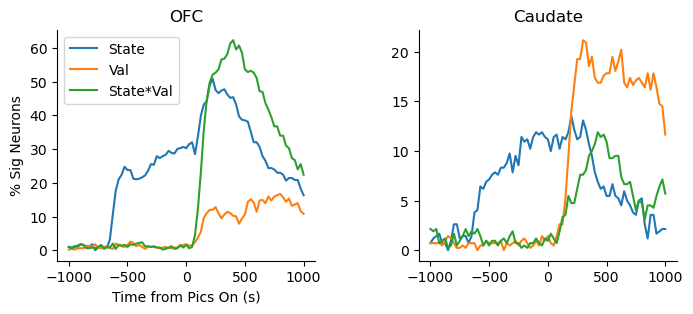

In [7]:
ofc_ix = brain_areas == 1
cdn_ix = brain_areas == 0

# pull out the factors
pure_state_ix = t_factor_pvals[: , :, 0] < .01
pure_val_ix = t_factor_pvals[: , :, 1] < .01
pure_cue_ix = t_factor_pvals[: , :, 2] < .01
state_val_ix = t_factor_pvals[: , :, 3] < .01
state_cue_ix = t_factor_pvals[: , :, 4] < .01

# set up some exclusive indices of the factors 
# - ensure that the approach of one inclusion and one exclusion criterion is universally applied
state_coding = pure_state_ix & ~state_cue_ix
val_coding = pure_val_ix & ~state_val_ix
state_val_coding = state_val_ix & ~pure_val_ix

fig, prop_ax = plt.subplots(1, 2, figsize=(8, 3))
plt.subplots_adjust(wspace=0.4, hspace=0.4)  # add some white space

prop_ax[0].plot(ts, np.mean(state_coding[ofc_ix , :], axis=0) * 100, label='State')
prop_ax[0].plot(ts, np.mean(val_coding[ofc_ix , :], axis=0) * 100, label='Val')
prop_ax[0].plot(ts, np.mean(state_val_ix[ofc_ix , :], axis=0) * 100, label='State*Val')
prop_ax[0].spines['top'].set_visible(False)
prop_ax[0].spines['right'].set_visible(False)
prop_ax[0].set_xlabel('Time from Pics On (s)')
prop_ax[0].set_ylabel('% Sig Neurons')
prop_ax[0].set_title('OFC')
prop_ax[0].legend()


prop_ax[1].plot(ts, np.mean(state_coding[cdn_ix , :], axis=0) * 100)
prop_ax[1].plot(ts, np.mean(val_coding[cdn_ix , :], axis=0) * 100)
prop_ax[1].plot(ts, np.mean(state_val_ix[cdn_ix , :], axis=0) * 100)
prop_ax[1].spines['top'].set_visible(False)
prop_ax[1].spines['right'].set_visible(False)
prop_ax[1].set_title('Caudate')



In [8]:
# let's try to understand the state code better with an AUROC analysis

# initialize arrays to accumulate results into
auc_scores = np.zeros((n_units, n_times, 4))
shuffle_auc_scores = np.zeros((n_units, n_times, 4)) 

# let's only look at the single-saccade trials for this
b_triasl2balance = bhv['n_sacc']==1

# pull a balanced set of trials
trials2use, leftover_ix = pull_balanced_train_set(b_triasl2balance, [bhv['state'].values, bhv['state_cue'].values])

# grab the firing rates and behavioral data associated with these trials
b_fr = firing_rates[trials2use, :, :]
b_state_label = bhv['state'].loc[trials2use]

# now loop over each neuron
for u in tqdm(range(n_units)):
    
    # loop over times
    for t in range(n_times):
        
        # run one-vs-all AUC classifiers for each state
        auc_scores[u, t, 0] = roc_auc_score(b_state_label == 1, b_fr[:,t,u])
        auc_scores[u, t, 1] = roc_auc_score(b_state_label == 2, b_fr[:,t,u])
        auc_scores[u, t, 2] = roc_auc_score(b_state_label == 3, b_fr[:,t,u])
        
        # also look just at the state 1 and 2 trials
        auc_scores[u, t, 3] = roc_auc_score(b_state_label[b_state_label < 3] == 1, b_fr[b_state_label < 3,t,u])
        
        # run the shuffles
        # shuffle the labels
        shuff_b_labels = np.random.permutation(b_state_label)
        
        # run one-vs-all AUC classifiers for each state
        shuffle_auc_scores[u, t, 0] = roc_auc_score(shuff_b_labels == 1, b_fr[:,t,u])
        shuffle_auc_scores[u, t, 1] = roc_auc_score(shuff_b_labels == 2, b_fr[:,t,u])
        shuffle_auc_scores[u, t, 2] = roc_auc_score(shuff_b_labels == 3, b_fr[:,t,u])
        
        # also look just at the state 1 and 2 trials
        shuffle_auc_scores[u, t, 3] = roc_auc_score(shuff_b_labels[shuff_b_labels < 3] == 1, b_fr[shuff_b_labels < 3,t,u])            
            
             
# rectify the scores
auc_scores[auc_scores < .5] = 1 - auc_scores[auc_scores < .5]
shuffle_auc_scores[shuffle_auc_scores < .5] = 1 - shuffle_auc_scores[shuffle_auc_scores < .5]

100%|██████████| 930/930 [07:06<00:00,  2.18it/s]


(-1000.0, 1000.0)

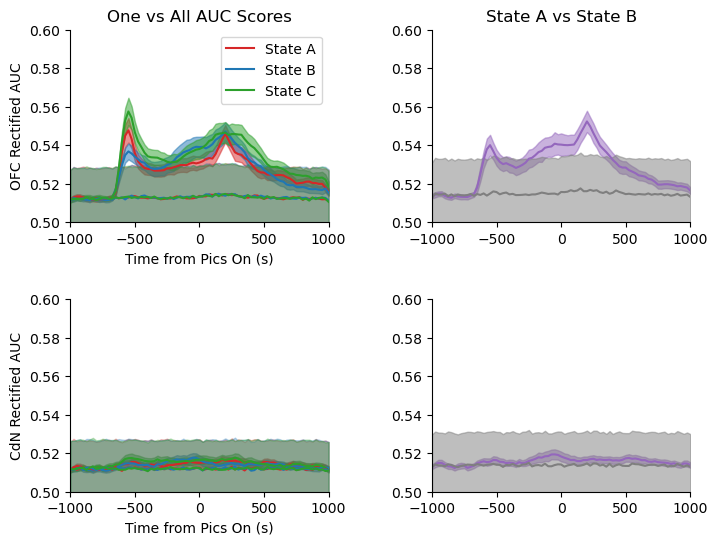

In [20]:
# compute mean and confidence intervals for the real data
state1_mean, state1_ci =  calculate_mean_and_interval(auc_scores[ofc_ix, :, 0], type='bootstrap', num_samples=1000, alpha=0.01)
state2_mean, state2_ci =  calculate_mean_and_interval(auc_scores[ofc_ix, :, 1], type='bootstrap', num_samples=1000, alpha=0.01)
state3_mean, state3_ci =  calculate_mean_and_interval(auc_scores[ofc_ix, :, 2], type='bootstrap', num_samples=1000, alpha=0.01)
state1vs2_mean, state1vs2_ci =  calculate_mean_and_interval(auc_scores[ofc_ix, :, 3], type='bootstrap', num_samples=1000, alpha=0.01)

# compute mean and confidence intervals for the shuffled data
s_state1_mean, s_state1_ci =  calculate_mean_and_interval(shuffle_auc_scores[ofc_ix, :, 0], type='percentile', num_samples=1000, alpha=0.01)
s_state2_mean, s_state2_ci =  calculate_mean_and_interval(shuffle_auc_scores[ofc_ix, :, 1], type='percentile', num_samples=1000, alpha=0.01)
s_state3_mean, s_state3_ci =  calculate_mean_and_interval(shuffle_auc_scores[ofc_ix, :, 2], type='percentile', num_samples=1000, alpha=0.01)
s_state1vs2_mean, s_state1vs2_ci =  calculate_mean_and_interval(shuffle_auc_scores[ofc_ix, :, 3], type='percentile', num_samples=1000, alpha=0.01)


fig, auc_ax = plt.subplots(2, 2, figsize=(8, 6))
plt.subplots_adjust(wspace=0.4, hspace=0.4)  # add some white space

# OFC

# plot the 1-vs-all scores
auc_ax[0,0].plot(ts, state1_mean, color='tab:red', label='State A')
auc_ax[0,0].fill_between(ts, state1_mean - state1_ci, state1_mean + state1_ci, color='tab:red', alpha = .5)
auc_ax[0,0].plot(ts, state2_mean, color='tab:blue', label='State B')
auc_ax[0,0].fill_between(ts, state2_mean - state2_ci, state2_mean + state2_ci, color='tab:blue', alpha = .5)
auc_ax[0,0].plot(ts, state3_mean, color='tab:green', label='State C')
auc_ax[0,0].fill_between(ts, state3_mean - state3_ci, state3_mean + state3_ci, color='tab:green', alpha = .5)

auc_ax[0,0].plot(ts, s_state1_mean, color='tab:red')
auc_ax[0,0].fill_between(ts, s_state1_mean - s_state1_ci, s_state1_mean + s_state1_ci, color='tab:red', alpha = .3)
auc_ax[0,0].plot(ts, s_state2_mean, color='tab:blue')
auc_ax[0,0].fill_between(ts, s_state2_mean - s_state2_ci, s_state2_mean + s_state2_ci, color='tab:blue', alpha = .3)
auc_ax[0,0].plot(ts, s_state3_mean, color='tab:green')
auc_ax[0,0].fill_between(ts, s_state3_mean - s_state3_ci, s_state3_mean + s_state3_ci, color='tab:green', alpha = .3)
auc_ax[0,0].spines['top'].set_visible(False)
auc_ax[0,0].spines['right'].set_visible(False)
auc_ax[0,0].set_ylim((.5, .6))
auc_ax[0,0].set_xlim((-1000, 1000))
auc_ax[0,0].set_ylabel('OFC Rectified AUC')
auc_ax[0,0].set_xlabel('Time from Pics On (s)')
auc_ax[0,0].set_title('One vs All AUC Scores')
auc_ax[0,0].legend()


# plot the state 1 vs state 2 scores
auc_ax[0,1].plot(ts, state1vs2_mean, color='tab:purple', label='State A vs B')
auc_ax[0,1].fill_between(ts, state1vs2_mean - state1vs2_ci, state1vs2_mean + state1vs2_ci, color='tab:purple', alpha = .5)
auc_ax[0,1].plot(ts, s_state1vs2_mean, color='tab:gray')
auc_ax[0,1].fill_between(ts, s_state1vs2_mean - s_state1vs2_ci, s_state1vs2_mean + s_state1vs2_ci, color='tab:gray', alpha = .5)
auc_ax[0,1].spines['top'].set_visible(False)
auc_ax[0,1].spines['right'].set_visible(False)
auc_ax[0,1].set_ylim((.5, .6))
auc_ax[0,1].set_xlim((-1000, 1000))
auc_ax[0,1].set_title('State A vs State B')

# Caudate

state1_mean, state1_ci =  calculate_mean_and_interval(auc_scores[cdn_ix, :, 0], type='bootstrap', num_samples=1000, alpha=0.01)
state2_mean, state2_ci =  calculate_mean_and_interval(auc_scores[cdn_ix, :, 1], type='bootstrap', num_samples=1000, alpha=0.01)
state3_mean, state3_ci =  calculate_mean_and_interval(auc_scores[cdn_ix, :, 2], type='bootstrap', num_samples=1000, alpha=0.01)
state1vs2_mean, state1vs2_ci =  calculate_mean_and_interval(auc_scores[cdn_ix, :, 3], type='bootstrap', num_samples=1000, alpha=0.01)

# compute mean and confidence intervals for the shuffled data
s_state1_mean, s_state1_ci =  calculate_mean_and_interval(shuffle_auc_scores[cdn_ix, :, 0], type='percentile', num_samples=1000, alpha=0.01)
s_state2_mean, s_state2_ci =  calculate_mean_and_interval(shuffle_auc_scores[cdn_ix, :, 1], type='percentile', num_samples=1000, alpha=0.01)
s_state3_mean, s_state3_ci =  calculate_mean_and_interval(shuffle_auc_scores[cdn_ix, :, 2], type='percentile', num_samples=1000, alpha=0.01)
s_state1vs2_mean, s_state1vs2_ci =  calculate_mean_and_interval(shuffle_auc_scores[cdn_ix, :, 3], type='percentile', num_samples=1000, alpha=0.01)

# plot the 1-vs-all scores
auc_ax[1,0].plot(ts, state1_mean, color='tab:red', label='State A')
auc_ax[1,0].fill_between(ts, state1_mean - state1_ci, state1_mean + state1_ci, color='tab:red', alpha = .5)
auc_ax[1,0].plot(ts, state2_mean, color='tab:blue', label='State B')
auc_ax[1,0].fill_between(ts, state2_mean - state2_ci, state2_mean + state2_ci, color='tab:blue', alpha = .5)
auc_ax[1,0].plot(ts, state3_mean, color='tab:green', label='State C')
auc_ax[1,0].fill_between(ts, state3_mean - state3_ci, state3_mean + state3_ci, color='tab:green', alpha = .5)

auc_ax[1,0].plot(ts, s_state1_mean, color='tab:red')
auc_ax[1,0].fill_between(ts, s_state1_mean - s_state1_ci, s_state1_mean + s_state1_ci, color='tab:red', alpha = .3)
auc_ax[1,0].plot(ts, s_state2_mean, color='tab:blue')
auc_ax[1,0].fill_between(ts, s_state2_mean - s_state2_ci, s_state2_mean + s_state2_ci, color='tab:blue', alpha = .3)
auc_ax[1,0].plot(ts, s_state3_mean, color='tab:green')
auc_ax[1,0].fill_between(ts, s_state3_mean - s_state3_ci, s_state3_mean + s_state3_ci, color='tab:green', alpha = .3)
auc_ax[1,0].spines['top'].set_visible(False)
auc_ax[1,0].spines['right'].set_visible(False)
auc_ax[1,0].set_ylim((.5, .6))
auc_ax[1,0].set_xlim((-1000, 1000))
auc_ax[1,0].set_ylabel('CdN Rectified AUC')
auc_ax[1,0].set_xlabel('Time from Pics On (s)')


# plot the state 1 vs state 2 scores
auc_ax[1,1].plot(ts, state1vs2_mean, color='tab:purple', label='State A vs B')
auc_ax[1,1].fill_between(ts, state1vs2_mean - state1vs2_ci, state1vs2_mean + state1vs2_ci, color='tab:purple', alpha = .5)
auc_ax[1,1].plot(ts, s_state1vs2_mean, color='tab:gray')
auc_ax[1,1].fill_between(ts, s_state1vs2_mean - s_state1vs2_ci, s_state1vs2_mean + s_state1vs2_ci, color='tab:gray', alpha = .5)
auc_ax[1,1].spines['top'].set_visible(False)
auc_ax[1,1].spines['right'].set_visible(False)
auc_ax[1,1].set_ylim((.5, .6))
auc_ax[1,1].set_xlim((-1000, 1000))


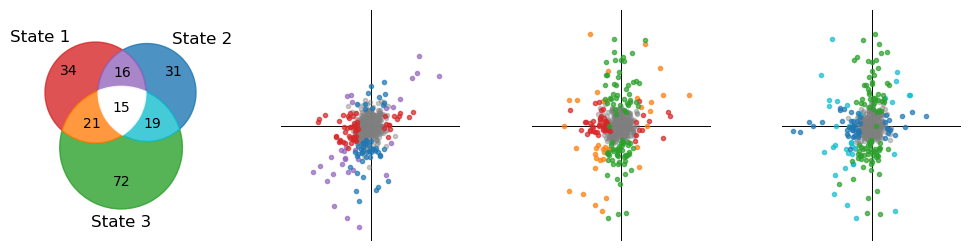

In [10]:
# scatter plot the value betas for each neuron in each state

# OFC

# create some indices for subject and brain area
area_ix = (brain_areas == 1) # 1= ofc, 0 = caudate

# Determine significant neurons
sig_units = (reg_pvals < .01) 

# Extract beta weights for the three states
betas1 = reg_betas[:, 0]
betas2 = reg_betas[:, 1]
betas3 = reg_betas[:, 2]

# Determine significance for each state
sig1 = sig_units[:, 0]
sig2 = sig_units[:, 1]
sig3 = sig_units[:, 2]
any_sig = sig1 | sig2 | sig3
ax_range = (-.6, .6)

# Windsorize values to the range of the plot
betas1[np.abs(betas1) > np.max(ax_range)] = 0
betas2[np.abs(betas2) > np.max(ax_range)] = 0
betas3[np.abs(betas3) > np.max(ax_range)] = 0

fig, scat_ax = plt.subplots(1, 4, figsize=(12, 3))
plt.subplots_adjust(wspace=0.4, hspace=0.4)  # add some white space

scat_ax[1].plot([0, 0], ax_range, color='k', zorder=1, linewidth = .7)
scat_ax[1].plot(ax_range, [0, 0], color='k', zorder=1, linewidth = .7)
scat_ax[1].scatter(betas1[~sig1 & ~sig2  & area_ix], betas2[~sig1 & ~sig2 & area_ix], color='tab:gray', zorder=2, alpha=.4, marker='.')
scat_ax[1].scatter(betas1[sig1 & sig2 & area_ix], betas2[sig1 & sig2 & area_ix], color='tab:purple', zorder=2, alpha=.7, marker='.')
scat_ax[1].scatter(betas1[sig1 & ~sig2 & area_ix], betas2[sig1 & ~sig2  & area_ix], color='tab:red', zorder=2, alpha=.7, marker='.')
scat_ax[1].scatter(betas1[~sig1 & sig2 & area_ix], betas2[~sig1 & sig2  & area_ix], color='tab:blue', zorder=2, alpha=.7, marker='.')
scat_ax[1].set_xlim(ax_range)
scat_ax[1].set_ylim(ax_range)
scat_ax[1].spines['top'].set_visible(False)
scat_ax[1].spines['bottom'].set_visible(False)
scat_ax[1].spines['right'].set_visible(False)
scat_ax[1].spines['left'].set_visible(False)  
scat_ax[1].yaxis.set_visible(False)
scat_ax[1].xaxis.set_visible(False)


scat_ax[2].plot([0, 0], ax_range, color='k', zorder=1, linewidth = .7)
scat_ax[2].plot(ax_range, [0, 0], color='k', zorder=1, linewidth = .7)
scat_ax[2].scatter(betas1[~sig1 & ~sig3 & area_ix], betas3[~sig1 & ~sig3 & area_ix], color='tab:gray', zorder=2, alpha=.4, marker='.')
scat_ax[2].scatter(betas1[sig1 & sig3 & area_ix], betas3[sig1 & sig3 & area_ix], color='tab:orange', zorder=2, alpha=.7, marker='.')
scat_ax[2].scatter(betas1[sig1 & ~sig3 & area_ix], betas3[sig1 & ~sig3 & area_ix], color='tab:red', zorder=2, alpha=.7, marker='.')
scat_ax[2].scatter(betas1[~sig1 & sig3 & area_ix], betas3[~sig1 & sig3 & area_ix], color='tab:green', zorder=2, alpha=.7, marker='.')
scat_ax[2].set_xlim(ax_range)
scat_ax[2].set_ylim(ax_range)
scat_ax[2].spines['top'].set_visible(False)
scat_ax[2].spines['bottom'].set_visible(False)
scat_ax[2].spines['right'].set_visible(False)
scat_ax[2].spines['left'].set_visible(False)  
scat_ax[2].yaxis.set_visible(False)
scat_ax[2].xaxis.set_visible(False)


scat_ax[3].plot([0, 0], ax_range, color='k', zorder=1, linewidth = .7)
scat_ax[3].plot(ax_range, [0, 0], color='k', zorder=1, linewidth = .7)
scat_ax[3].scatter(betas2[~sig2 & ~sig3 & area_ix], betas3[~sig2 & ~sig3 & area_ix], color='tab:gray', zorder=2, alpha=.4, marker='.')
scat_ax[3].scatter(betas2[sig2 & sig3 & area_ix], betas3[sig2 & sig3 & area_ix], color='tab:cyan', zorder=2, alpha=.7, marker='.')
scat_ax[3].scatter(betas2[sig2 & ~sig3 & area_ix], betas3[sig2 & ~sig3 & area_ix], color='tab:blue', zorder=2, alpha=.7, marker='.')
scat_ax[3].scatter(betas2[~sig2 & sig3 & area_ix], betas3[~sig2 & sig3 & area_ix], color='tab:green', zorder=2, alpha=.7, marker='.')
scat_ax[3].set_xlim(ax_range)
scat_ax[3].set_ylim(ax_range)
scat_ax[3].spines['top'].set_visible(False)
scat_ax[3].spines['bottom'].set_visible(False)
scat_ax[3].spines['right'].set_visible(False)
scat_ax[3].spines['left'].set_visible(False)  
scat_ax[3].yaxis.set_visible(False)
scat_ax[3].xaxis.set_visible(False)

# Create sets of significant neurons for each task state
set1 = set(np.where(sig_units[area_ix, 0])[0])
set2 = set(np.where(sig_units[area_ix, 1])[0])
set3 = set(np.where(sig_units[area_ix, 2])[0])
# Plot Venn diagram
u_venn = venn3([set1, set2, set3], ('State 1', 'State 2', 'State 3'), ax=scat_ax[0])
# Define colors for each set
colors = {'100': 'tab:red', '010': 'tab:blue', '001': 'tab:green',
          '110': 'tab:purple', '101': 'tab:orange', '011': 'tab:cyan', '111': 'white'}

# Apply colors to the regions
for region_id, color in colors.items():
    u_venn.get_patch_by_id(region_id).set_color(color)
    u_venn.get_patch_by_id(region_id).set_alpha(0.8)  # Optional: set transparency


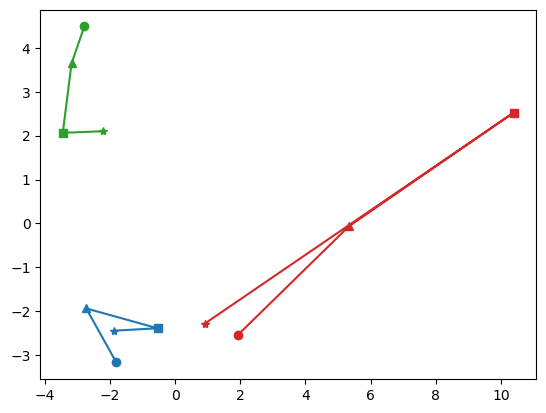

In [11]:
# Perform PCA and determine the value manifold

ofc_pca = decomposition.PCA(n_components=6)
ofc_pca.fit(f_cond_means[:, ofc_ix])
ofc_pcs = ofc_pca.transform(f_cond_means[:, ofc_ix])

x_ax = 0
y_ax = 1

# visualize the manifold
markers = ['o', '^', 's', '*']
for i in range(4):
    plt.plot(ofc_pcs[i+0,x_ax], ofc_pcs[i+0,y_ax], marker = markers[i], color='tab:blue')
    plt.plot(ofc_pcs[i+4,x_ax], ofc_pcs[i+4,y_ax], marker = markers[i], color='tab:red')
    plt.plot(ofc_pcs[i+8,x_ax], ofc_pcs[i+8,y_ax], marker = markers[i], color='tab:green')
    
plt.plot(ofc_pcs[0:4,x_ax], ofc_pcs[0:4,y_ax], color = 'tab:blue')
plt.plot(ofc_pcs[4:8,x_ax], ofc_pcs[4:8,y_ax], color = 'tab:red')
plt.plot(ofc_pcs[8:12,x_ax], ofc_pcs[8:12,y_ax], color = 'tab:green')